This notebook re-analyses mass-spectrometry data in [Gauglitz et al](https://msystems.asm.org/content/5/2/e00635-19). The mass spectrometry data and methods for this dataset have been
deposited on the GNPS/MassIVE public repository under the accession number [MSV000082969](ftp://massive.ucsd.edu/MSV000082969).

In [1]:
import qiime2.plugins.diversity.actions as q2_diversity
import qiime2.plugins.feature_table.actions as q2_feature_table
from qiime2 import Artifact
from qiime2 import Metadata
import qiime2 as q2
import unifrac
from biom import load_table

from skbio import DistanceMatrix, OrdinationResults
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
from skbio import OrdinationResults
from skbio.stats.distance import permanova
from skbio.tree import TreeNode
from skbio.stats.ordination import pcoa
from skbio.diversity import beta_diversity
from scipy.cluster.hierarchy import linkage
from scipy.stats import kruskal

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['pdf.fonttype'] = 42
%matplotlib inline

In [2]:
def load_mf(fn, index='#SampleID', sep='\t'):
    _df = pd.read_csv(fn, sep=sep, dtype='str', na_values=[], keep_default_na=False)
    _df.set_index(index, inplace=True)
    return _df

In [3]:
mapping = load_mf("data/20190429_Cheetah_metadata.txt")

Per co-author request, we rename the Wildlife Discoveries category to WD

In [4]:
mapping.ATTRIBUTE_sampled_location.replace({'Wildlife Discoveries': 'WD'}, inplace=True)

The feature tables, trees and fingerprints were processed using [q2-qemistree](https://github.com/biocore/q2-qemistree) CLI.

In [5]:
table = q2.Artifact.load('data/ftable_cheetah.qza')
tree = q2.Artifact.load('data/tree_cheetah.qza')

Filter to keep only fecal samples and fix the metadata to remove any trailing whitespaces and empty cells.

In [6]:
_mapping = mapping.copy()
_mapping.replace(to_replace='', value='NA', inplace=True)
_mapping = _mapping.apply(lambda x: x.str.strip().copy())

# first remove the blank samples, note this depends in a column that was created a few cells above
_table, = q2_feature_table.filter_samples(table=table,
                                          metadata=q2.Metadata(_mapping),
                                          where='body_product = "UBERON:feces"')

results = {}
for metric in ['Bray-Curtis', 'Weighted UniFrac']:

    if metric == 'Bray-Curtis':
        dm, = q2_diversity.beta(table=_table, metric='braycurtis')
    elif metric == 'Weighted UniFrac':
        dm, = q2_diversity.beta_phylogenetic(table=_table, phylogeny=tree,
                                             metric='weighted_normalized_unifrac', n_jobs=2)
    else:
        raise ValueError("Not expecting this metric %s" % metric)

    results[metric] = {}
    results[metric]['dm'] = dm.view(DistanceMatrix)
    results[metric]['pcoa'] = q2_diversity.pcoa(dm)[0].view(OrdinationResults)

/Users/priya/miniconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.9435926354256843 and the largest is 21.62794656426457.
  RuntimeWarning
/Users/priya/miniconda3/envs/qiime2-2019.7/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes sect

Create a set of 4 panels featuring the Bray-Curtis and Weighted UniFrac matrices colored by plate number and by host type. Each panel includes the results from running PERMANOVA, expect some slow-downs.

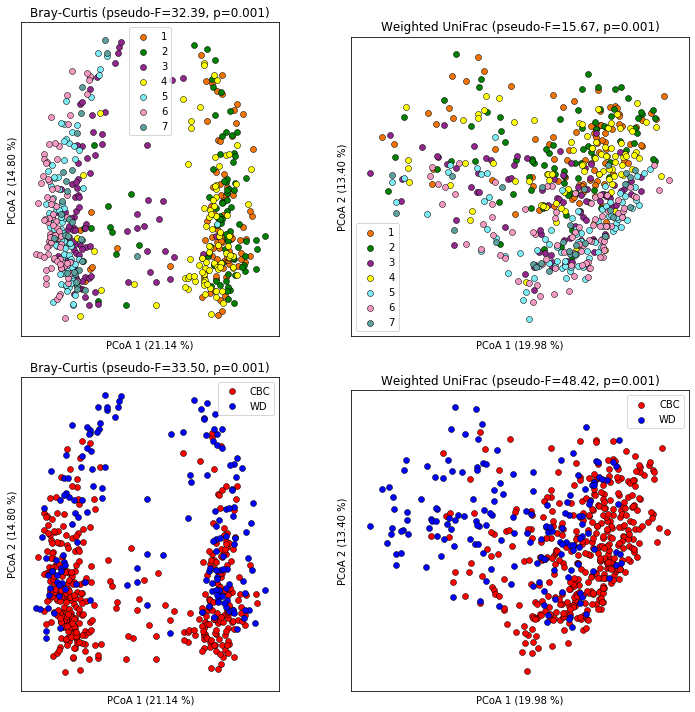

In [7]:
colors = {
    'CBC': 'red',
    'WD': 'blue',
    
    '1': '#f27304',
    '2': '#008000',
    '3': '#91278d',
    '4': '#ffff00',
    '5': '#7cecf4',
    '6': '#f49ac2',
    '7': '#5da09e',
}

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False, figsize=(10, 10))

# save the distance comparisons for each metric
distances = []

# transpose the axes array so that we can go column by column
for metric, axs in zip(['Bray-Curtis', 'Weighted UniFrac'], axes.T):

    for category, ax in zip(['plate_num_old', 'ATTRIBUTE_sampled_location'], axs):
        ax.set_aspect(1, adjustable='box', anchor='SW')
        
        pc = results[metric]['pcoa']
        _mapping = mapping.loc[pc.samples.index]
        
        # compute permanova
        _pmnv = permanova(results[metric]['dm'], _mapping[category])
        f, p = _pmnv['test statistic'], _pmnv['p-value']
        
        ax.set_title('%s (pseudo-F=%.2f, p=%.3f)' % (metric, f, p))

        
        for category_set, _df in _mapping.groupby(category):
            _pc = pc.samples.loc[_df.index]

            ax.scatter(_pc.iloc[:, 0], _pc.iloc[:, 1],
                        c=colors.get(category_set, None),
                        edgecolors='black', linewidth=0.5,
                        label=category_set)

            ax.set_xlabel('PCoA 1 (%.2f %%)' % (pc.proportion_explained[0] * 100))
            ax.set_ylabel('PCoA 2 (%.2f %%)' % (pc.proportion_explained[1] * 100))

            # remove the ticks and coordinate values
            ax.set_xticks([])
            ax.set_yticks([])

            ax.legend()

fig.tight_layout()

fig.savefig('figures/cheetah_metabolome_PCoA.pdf')